# Analysis of different Candidate Set Reduction Strategies

In [1]:
%load_ext autoreload
%autoreload 2

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation
from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, tanimoto_kernel
from matchms.Spectrum import Spectrum

from ssvm.data_structures import CandidateSQLiteDB, RandomSubsetCandidateSQLiteDB, CentroidCandidateSQLiteDB

## Look at individual Example Spectra

First we load all candidates for one spectrum and run a dimensionallity reduction algorithm on it. We want to represent the molecular space in a 2D plane. 

In [2]:
spectrum_id = "Challenge-016"
# spectrum_id = "Challenge-010"
spectrum = Spectrum(np.array([]), np.array([]), {"spectrum_id": spectrum_id})

In [3]:
candidate_db = CandidateSQLiteDB("/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db")

X = candidate_db.get_molecule_features(spectrum, "iokr_fps__positive")
ids = candidate_db.get_labelspace(spectrum)
KX = tanimoto_kernel(X)

Z_pca = KernelPCA(n_components=2, n_jobs=4, kernel="precomputed").fit_transform(KX)
Z_mds = MDS(n_components=2, n_jobs=4, dissimilarity="precomputed").fit_transform(1 - KX)

We compare the strategy of selecting all candidates with randomly sub-sampling candidates.

In [4]:
rand_candidate_db = RandomSubsetCandidateSQLiteDB(0.01, random_state=102, db_fn="/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db")

ids_rand = rand_candidate_db.get_labelspace(spectrum)

print(len(ids), len(ids_rand))

2233 22


Plot the molecule space:

Text(0.5, 1.0, 'MDS')

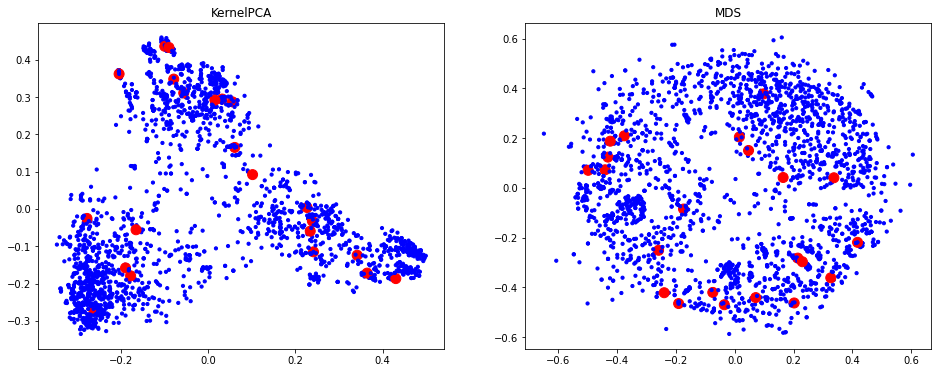

In [5]:
color = []
sizes = []
for i in ids:
    if i in ids_rand:
        color.append("red")
        sizes.append(100)
    else:
        color.append("blue")
        sizes.append(10)

fig, axrr = plt.subplots(1, 2, figsize=(16, 6))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=color, s=sizes)
axrr[0].set_title("KernelPCA")

axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=color, s=sizes)
axrr[1].set_title("MDS")

In [7]:
cent_candidate_db = CentroidCandidateSQLiteDB("iokr_fps__positive", 0.01, random_state=102,
                                              db_fn="/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db")

ids_cent = cent_candidate_db.get_labelspace(spectrum)

print(len(ids), len(ids_cent))

2233 22


Text(0.5, 1.0, 'MDS')

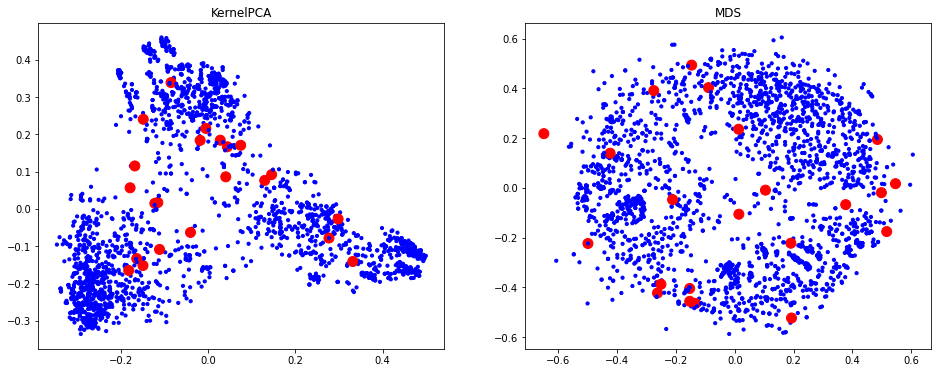

In [8]:
color = []
sizes = []
for i in ids:
    if i in ids_cent:
        color.append("red")
        sizes.append(100)
    else:
        color.append("blue")
        sizes.append(10)

fig, axrr = plt.subplots(1, 2, figsize=(16, 6))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=color, s=sizes)
axrr[0].set_title("KernelPCA")

axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=color, s=sizes)
axrr[1].set_title("MDS")

It seems that a random sub-sample of the candidates covers the molecular space well in our example.

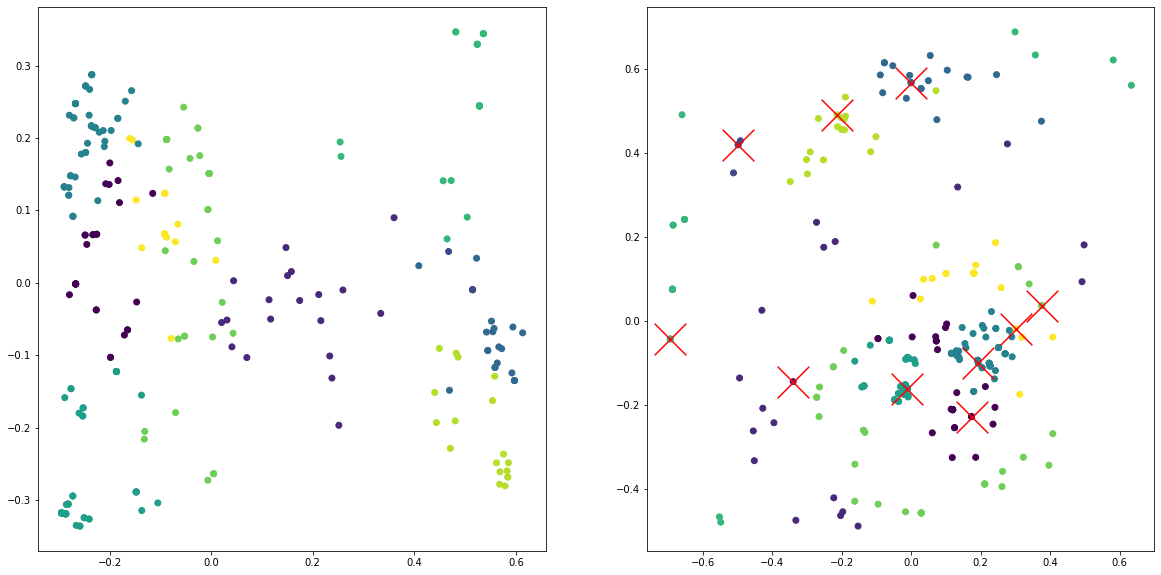

In [190]:
def get_centroids(S, cluster):
    c = cluster.fit_predict(S)
    
    centroids = []
    idc = np.arange(len(c))
    for label in np.unique(c):
        idx_of_centroid = idc[c == label][np.argsort(np.median(S[np.ix_(c == label, c == label)], axis=0))[::-3][:1]] 
        centroids.append(idx_of_centroid)

    return c, centroids

c, cen = get_centroids(KX, MiniBatchKMeans(n_clusters=10, n_init=20, init='k-means++'))

fig, axrr = plt.subplots(1, 2, figsize=(20, 10))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=c)
axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=c)
axrr[1].scatter(Z_mds[cen, 0], Z_mds[cen, 1], c="red", marker="x", s=1000)

In [148]:
Z_mds[cen, 0]

array([ 0.04340301, -0.40268335,  0.37689795,  0.46666394, -0.00652842,
       -0.36619133,  0.27165585, -0.11956878])

In [86]:
c = MiniBatchKMeans().fit_predict(X)

In [75]:
X = load_features("Challenge-100", "iokr_fps__positive")
y = KMeans(X).fit_predict()

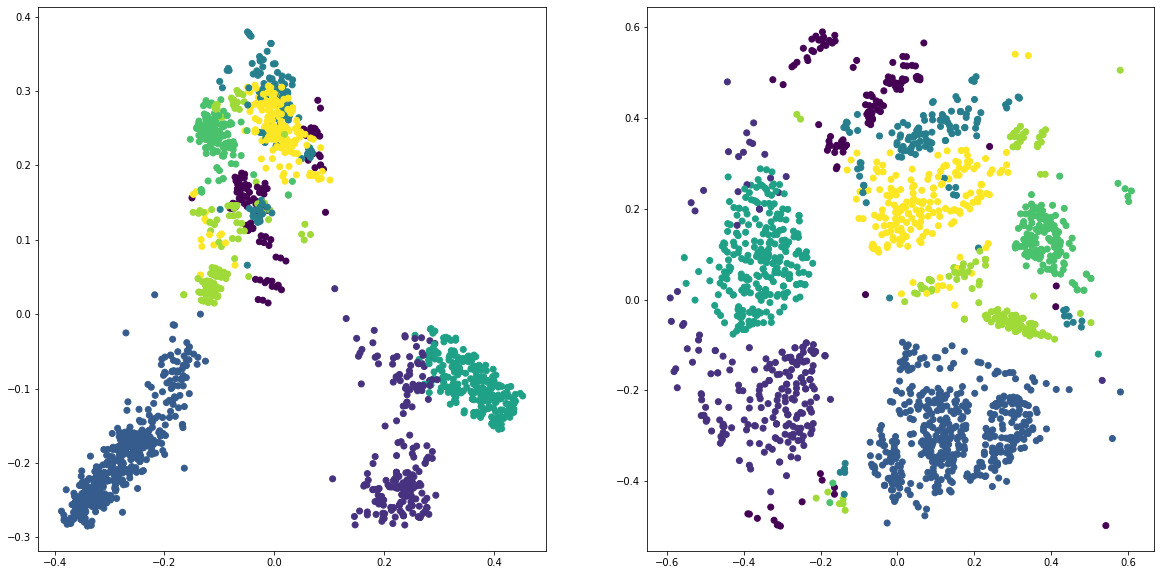

In [78]:
fig, axrr = plt.subplots(1, 2, figsize=(20, 10))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=y)
axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=y)